In [155]:
import numpy as np
import seaborn as sns; sns.set()

from keras.datasets import mnist

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

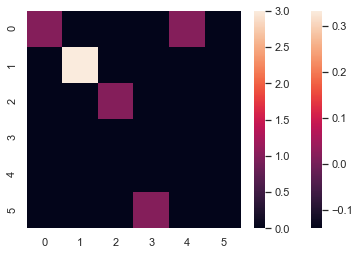

In [174]:

ax = sns.heatmap(weights_1_2)

def predict(image):
    layer_0 = image.reshape(1, PIXELS_PER_IMAGE)/255
    layer_1 = relu(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)
    
    print(np.argmax(layer_2))

    
def confusion_matrix(y_pred, y_true):
    unique_values = list(set(y_true) | set(y_pred))
    mtrx = np.zeros((len(unique_values), len(unique_values)))
    for y_p, y_t in zip(y_pred, y_true):
        mtrx[unique_values.index(y_p)][unique_values.index(y_t)] += 1
    return mtrx, unique_values

mtrx,_ = confusion_matrix([1,2,2,16,3,1,2], [1,2,2,6,3,14,2])
sns.heatmap(mtrx)

In [23]:
PIXELS_PER_IMAGE = 28*28
UNIQUE_LABELS = np.unique(y_test)

PIXELS_PER_IMAGE, UNIQUE_LABELS

(784, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [157]:
def one_hot_encoder(array):
    """
    Encodes vector into the one hot matrix.
    """
    unique_values = np.unique(array)
    one_hot_labels = np.zeros((len(array), len(unique_values)))
    for i, el in enumerate(array):
        one_hot_labels[i][np.where(unique_values==el)[0]] = 1
    return one_hot_labels


def img_label_generator(images, labels, batch_size=1):
    """
    Yields pair of (data, label) with given batch size
    """
    count_of_images = len(images)
    assert count_of_images == len(labels)
    for  i in range(int(count_of_images//batch_size)):
        yield images[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size]

relu = lambda x: (x >= 0) * x
relu2deriv = lambda output: output >= 0


## Data prepearing

In [55]:
images = x_train[:1000].reshape(1000, PIXELS_PER_IMAGE)/255
labels = one_hot_encoder(y_train[:1000])

test_images = x_test.reshape(len(x_test), PIXELS_PER_IMAGE)/255
test_labels = one_hot_encoder(y_test)

## Model hyperparameters

In [51]:
alpha = 0.01
iterations = 300
hidden_size = 40
batch_size = 100

### Training process

In [ ]:
# %%time

np.random.seed(1)

weights_0_1 = 0.2 * np.random.random((PIXELS_PER_IMAGE, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, len(UNIQUE_LABELS)))

history = []   # Created for storing error and accuracy metrics 

for iteration in range(iterations):
    err, correct_cnt = .0, .0
    
    for img_chunk, labels_chunk in img_label_generator(images, labels, batch_size=batch_size):
        
        layer_0 = img_chunk
        
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        
        layer_2 = np.dot(layer_1, weights_1_2)
              
        err += np.sum((labels_chunk - layer_2) ** 2)  # squared error
        for layer_val, label in img_label_generator(layer_2, labels_chunk):
            correct_cnt += int(np.argmax(layer_val)) == np.argmax(label)

            layer_2_delta = (labels_chunk - layer_2)/batch_size
            
            #Back propagation
            layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
            layer_1_delta *= dropout_mask
            
            #Weights updating
            weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
            
    if iteration % 10 == 0:
        test_err, test_correct_cnt = 0, 0
        err = err/len(images)
        correct_cnt = correct_cnt/len(images)
        
        print(f"Iteration: {iteration} \nError: {err:.4f} Acc: {correct_cnt:.4f}")
        for img, label in img_label_generator(test_images, test_labels):
            layer_0 = img
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)
            
            test_err += np.sum((label - layer_2) ** 2)
            test_correct_cnt += np.argmax(label) == np.argmax(layer_2)
            test_acc = test_correct_cnt/len(test_images)
        print(f"Test-error: {test_err/len(test_images):.3f} \Test-acc: {test_acc:.3f}")
        history.append(((err, acc), (test_err, test_acc)))


In [133]:
hist_err = [[train[0], test[0]/1000] for train, test in history]

In [138]:

err = [err[0] for err in hist_err]

/Users/maksimorluk/PycharmProjects/grokking_dl/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


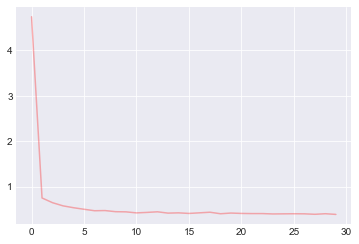

In [141]:
# history
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df=pd.DataFrame({'x': range(len(err)), 'y':  err})
plt.plot( 'x', 'y', data=df, color='red', alpha=0.3)
plt.show()


Text(0, 0.5, 'Score')

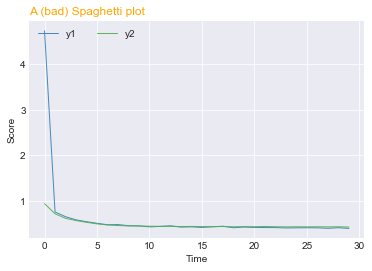

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': range(len(hist_err)),
                 'y1': [err[0] for err in hist_err],
                 'y2': [err[1]/10 for err in hist_err]})
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")
